Predicting Coca Cola Stock price using past 2 years of data and ARIMA modelling

Data Courtesy: Yahoo Finance

This code snippet uses the yfinance library to fetch historical stock price data for Coca-Cola (ticker symbol "KO") from Yahoo Finance. Specifically, it retrieves data for the past 2 years (from November 1, 2020, to November 1, 2022)

In [19]:
import yfinance as yf

# Define the ticker symbol for Coca-Cola (KO)
ticker = "KO"

# Define the date range for the past 2 years
end_date = "2022-11-01"  # End date is today
start_date = "2020-11-01"  # Two years before end date

# Fetch the data from Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date, progress=False)

# Print the first few rows of the data
print(data.head())


                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2020-11-02  48.750000  48.950001  48.240002  48.619999  44.384850  15156100
2020-11-03  49.220001  49.959999  49.000000  49.349998  45.051270  15285100
2020-11-04  49.430000  50.209999  49.080002  49.169998  44.886951  12930800
2020-11-05  49.759998  50.209999  49.340000  49.439999  45.133430  12452400
2020-11-06  49.650002  49.990002  49.250000  49.450001  45.142551   9294900


In [20]:
# Import necessary libraries
import pandas as pd     # For data manipulation and analysis
import numpy as np      # For numerical operations
import matplotlib.pyplot as plt    # For creating visualizations
from statsmodels.tsa.arima.model import ARIMA   # For performing ARIMA modeling


The code assumes that data is a DataFrame containing stock data with a column named 'Close' representing the closing prices over time. We prepare a plot of the closing price data.

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


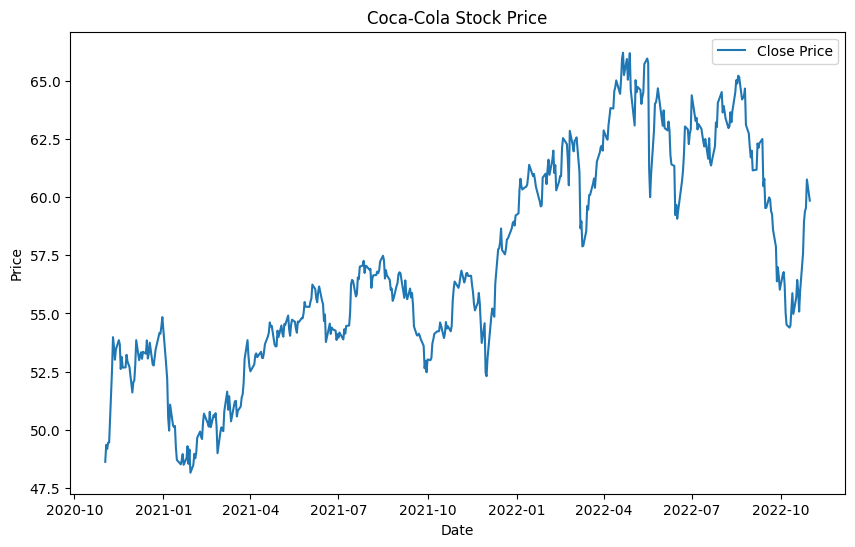

In [21]:
# Assuming 'data' is the DataFrame containing the stock data
# You may need to adjust column names if they are different in your dataset

# Check for missing values
print(data.isnull().sum())

# If there are missing values, you may need to handle them before proceeding

# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Close Price')
plt.title('Coca-Cola Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


this code segment checks for stationarity in the time series data using the Augmented Dickey-Fuller test 

In [22]:
# Check for stationarity using the Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# If the p-value is less than a significance level (e.g., 0.05), you can reject the null hypothesis and consider the data as stationary.


ADF Statistic: -2.1142960224249294
p-value: 0.2388050904629999
Critical Values: {'1%': -3.4434437319767452, '5%': -2.8673146875484368, '10%': -2.569845688481135}


Since P value is greater than 0.05 we can't reject the null. The series is non stationary and we need to make it stationary

This code segment provides a way to check for stationarity after differencing the data. If the differenced data is stationary, it suggests that ARIMA modeling can be considered for further analysis.

In [23]:
# If the data is not stationary, you may need to take differences to make it stationary
data_diff = data['Close'].diff().dropna()

# Check stationarity again after differencing
result_diff = adfuller(data_diff)
print('ADF Statistic (after differencing):', result_diff[0])
print('p-value (after differencing):', result_diff[1])
print('Critical Values (after differencing):', result_diff[4])

# If the data is now stationary, you can proceed with ARIMA modeling


ADF Statistic (after differencing): -21.537850980214134
p-value (after differencing): 0.0
Critical Values (after differencing): {'1%': -3.443470002903981, '5%': -2.867326248740681, '10%': -2.569851849873108}


After first differencing the P value is <0.05 and we can say that the first difference of the series is stationary

Overall, this code segment calculates and visualizes the first differences of the 'Close' prices, which is a common step in time series analysis for making non-stationary data more stationary. The resulting plot will show the changes in price from one time period to the next.


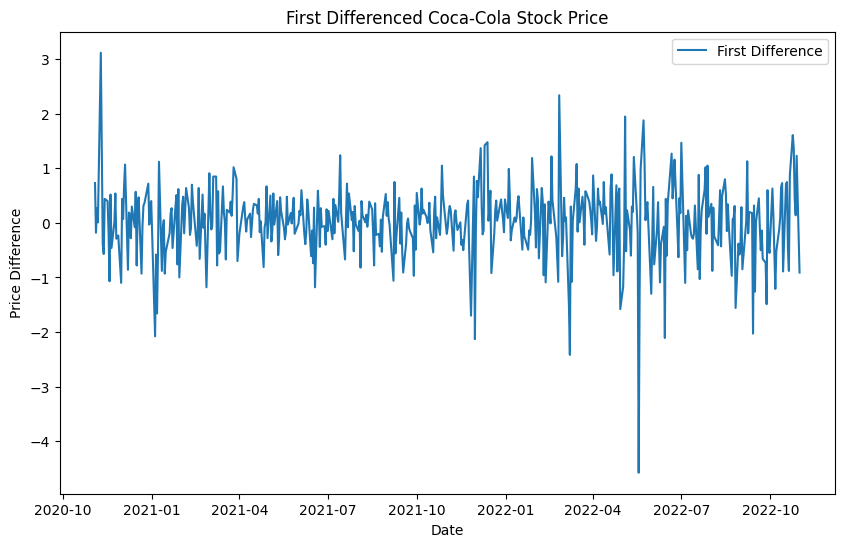

In [24]:
# Compute the first differences
data['Close_diff'] = data['Close'].diff()

# Plot the first differenced data
plt.figure(figsize=(10, 6))
plt.plot(data['Close_diff'], label='First Difference')
plt.title('First Differenced Coca-Cola Stock Price')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend()
plt.show()


this code segment generates ACF and PACF plots for the differenced data. These plots are useful for identifying potential autoregressive (AR) and moving average (MA) components in time series modeling.

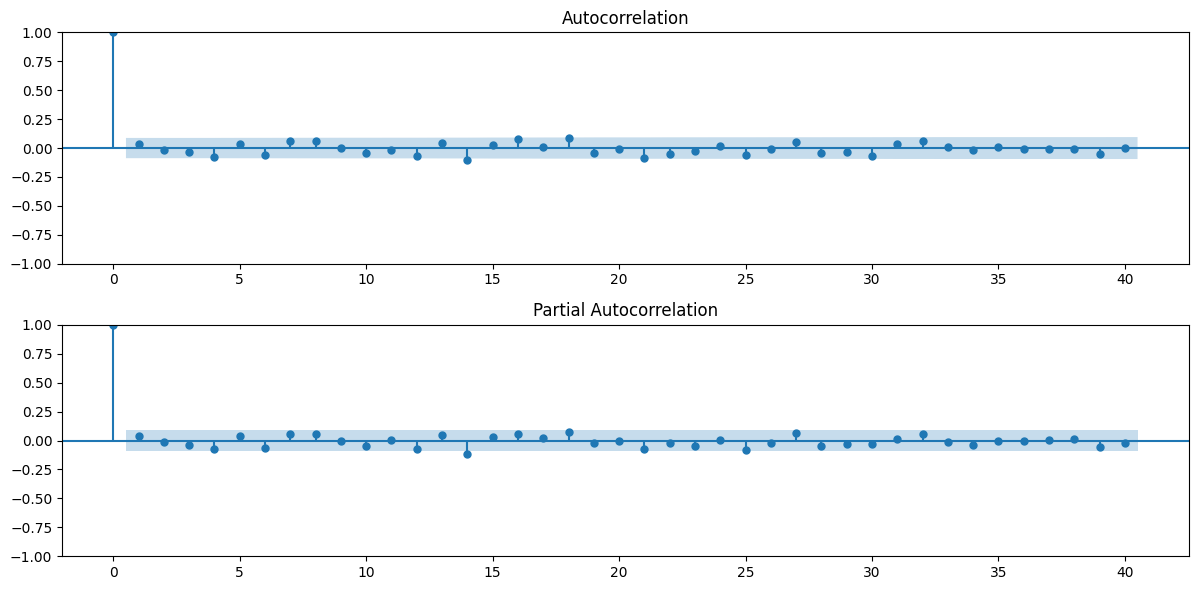

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(data_diff, ax=plt.gca(), lags=40)
plt.subplot(2, 1, 2)
plot_pacf(data_diff, ax=plt.gca(), lags=40)
plt.tight_layout()
plt.show()


this code segment performs an exhaustive search through combinations of p, d, and q values to find the best-fitting ARIMA model for the given data. The model with the lowest AIC is considered the best.

In [26]:
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA

# Define a range of values for p, d, and q
p_values = range(0, 6)  # Example range for p
d_values = range(0, 2)  # Example range for d
q_values = range(0, 6)  # Example range for q

# Create a list of all possible combinations of p, d, and q
pdq_combinations = list(itertools.product(p_values, d_values, q_values))

# Initialize variables to store best parameters and lowest AIC
best_params = None
best_aic = float('inf')

# Suppress ARIMA warnings for convergence
warnings.filterwarnings("ignore")

# Loop through all combinations and fit ARIMA models
for order in pdq_combinations:
    try:
        model = ARIMA(data['Close'], order=order)
        results = model.fit()
        aic = results.aic
        if aic < best_aic:
            best_aic = aic
            best_params = order
    except:
        continue

# Print the best parameters and AIC
print(f'Best ARIMA Model Order: {best_params} | AIC: {best_aic}')



Best ARIMA Model Order: (5, 1, 5) | AIC: 1016.1781472347691


this code segment guides you through the process of choosing appropriate values for p and q based on ACF and PACF plots, and then fitting the ARIMA model with those chosen parameters. It also provides a summary of the model's results.

In [27]:
# Based on the ACF and PACF plots, choose appropriate values for p and q
# For example, if ACF drops off sharply and PACF cuts off after lag 1, you might choose ARIMA(1,0,0) or ARIMA(1,0,1)

# Fit ARIMA model
p = 5  # Example value, adjust as needed
d = 1  # Example value, adjust as needed
q = 5  # Example value, adjust as needed

model = ARIMA(data['Close'], order=(p, d, q))
results = model.fit()

# Print summary of the model
print(results.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  503
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -497.089
Date:                Sun, 05 Nov 2023   AIC                           1016.178
Time:                        06:49:50   BIC                           1062.583
Sample:                             0   HQIC                          1034.384
                                - 503                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6227      0.124     -5.007      0.000      -0.866      -0.379
ar.L2          0.1938      0.036      5.356      0.000       0.123       0.265
ar.L3          0.1648      0.034      4.838      0.0

this code segment demonstrates how to split the data into training and test sets, fit an ARIMA model on the training data, and use the model to forecast future values. It also shows how to extract and print the forecasted values and confidence intervals.

In [28]:
# Use a portion of the data (holdout set) to validate the model's performance
train_size = int(len(data) * 0.8)
train, test = data['Close'][:train_size], data['Close'][train_size:]

# Fit ARIMA model on the training data
model = ARIMA(train, order=(p, d, q))
results = model.fit()

# Forecast on the test set
forecast_steps = len(test)
forecast = results.get_forecast(steps=forecast_steps)

# Get forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Print forecasted values and confidence intervals
print(forecast_values)
print(confidence_intervals)


402    63.551376
403    63.590531
404    63.117068
405    62.863114
406    62.543291
         ...    
498    62.833235
499    62.934472
500    63.032384
501    63.077666
502    63.056918
Name: predicted_mean, Length: 101, dtype: float64
     lower Close  upper Close
402    62.316372    64.786380
403    61.811064    65.369999
404    60.971989    65.262147
405    60.430870    65.295359
406    59.873600    65.212982
..           ...          ...
498    50.751170    74.915300
499    50.787829    75.081115
500    50.821238    75.243531
501    50.802898    75.352434
502    50.720212    75.393625

[101 rows x 2 columns]


this code segment generates a plot visualizing the training data, actual test data, forecasted data, and confidence intervals. It provides a visual representation of how well the ARIMA model's forecasts align with the actual data.

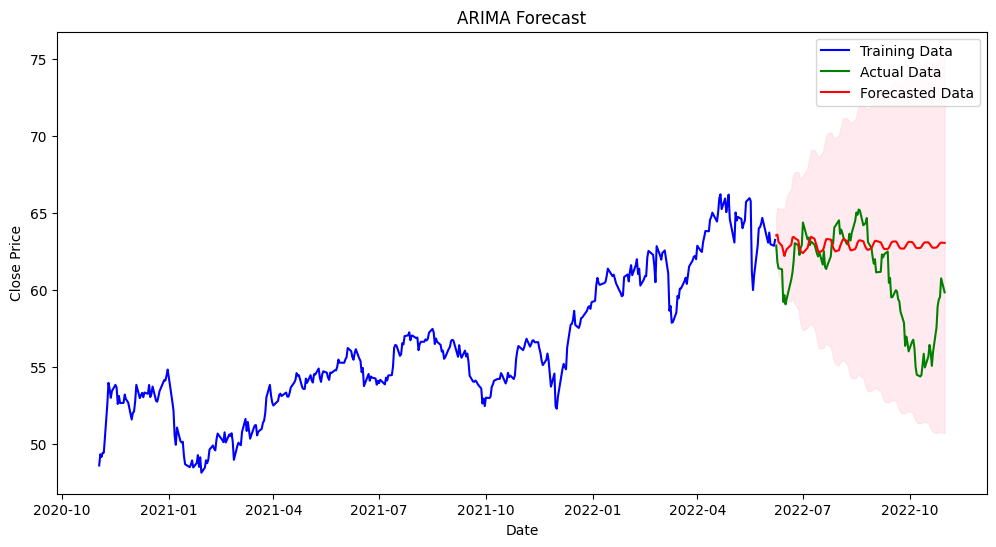

In [29]:
import matplotlib.pyplot as plt

# Plot the actual and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, label='Training Data', color='blue')
plt.plot(test.index, test.values, label='Actual Data', color='green')
plt.plot(test.index, forecast_values.values, label='Forecasted Data', color='red')

# Plot the confidence intervals
plt.fill_between(test.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)

# Add labels and legend
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Show the plot
plt.show()


Pros:

    1. Account for Trend and Seasonality:
        ARIMA models can capture both trend and seasonality in time series data. This makes them suitable for a wide range of applications.

    2. Interpretability:
        The parameters of an ARIMA model (p, d, q) have clear and interpretable meanings.
        p represents the autoregressive order, d represents the differencing order, and q represents the moving average order.

    3. No External Variables Needed:
        ARIMA models only require the time series data itself, making them easy to implement without additional data sources.

    4. Predictive Power:
        ARIMA models can provide accurate forecasts for a wide range of time series data, especially when the underlying process follows a stationary or nearly-stationary pattern.

Cons:

    1. Limited Handling of Non-Linear Relationships:
        ARIMA models assume a linear relationship between the past observations and the current observation. They may not perform well on time series data with highly non-linear patterns.

    2. Sensitive to Model Specification:
        Selecting the appropriate orders p, d, and q can be challenging. A poor choice of these parameters can lead to inaccurate forecasts.

    3. Difficulty Handling Large or Complex Datasets:
        ARIMA models can become computationally intensive and less effective when dealing with large datasets or time series with complex patterns.

    4. May Not Capture External Factors:
        ARIMA models do not naturally incorporate external variables or exogenous factors that may influence the time series. This can be a limitation in cases where external factors play a significant role.

    5. Assumes Stationarity:
        ARIMA models require the time series to be stationary. If the data is non-stationary, it must be differenced, which can sometimes lead to loss of interpretability.

    6. Not Suitable for Irregularly Sampled Data:
        ARIMA models are designed for regularly spaced time series data. They may not perform well on data with irregular time intervals.

    7. May Overfit if Over-Parameterized:
        Using high values of p, d, or q can lead to overfitting, especially if the data does not warrant such complexity.